# Calculate Nino 3.4 Time Series using CMIP6 CESM2 model

In this notebook we calculate the Nino 3.4 index for the CESM2 CMIP6 submission using the sea surface temperature from the ocean model component.

* Load data
* Calculate a monthly climatology of mean SST for the 1950-1979 period
* Compare the values of climatological mean SST with those from the classic Trenberth paper
* Calculate the Nino 3.4 index
* Moving average smoother
* Data normalisation
* A bit play with time series plotting

This example uses Coupled Model Intercomparison Project (CMIP6) collections. For more information, please visit [data catalogue]( https://geonetwork.nci.org.au/geonetwork/srv/eng/catalog.search#/metadata/f6600_2266_8675_3563) and [terms of use]( https://pcmdi.llnl.gov/CMIP6/TermsOfUse/TermsOfUse6-1.html).

---------

- Authors: NCI Virtual Research Environment Team
- Keywords: CMIP, xarray, CESM, Nino34 Index
- Create Date: 2020-Apr
- Lineage/Reference: This example was modified from the original example developed by Dr Aidan Heerdegen from ARC COE Clex group
---

## Nino 3.4 index 

The definition of Nino 3.4 index can be found [here](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni).

> Niño 3.4 (5N-5S, 170W-120W):  The  Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast.  The Niño 3.4 index typically uses a 5-month running mean, and El Niño or La  Niña events are defined when the  Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more.

> Nino X Index computation: (a) Compute area averaged total SST from Niño X region; (b) Compute monthly climatology (e.g., 1950-1979) for area averaged total SST from Niño X region, and subtract climatology from area averaged total SST time series to obtain anomalies; (c) Smooth the anomalies with a 5-month running mean; (d) Normalize the smoothed values by its standard deviation over the climatological period.

#### Import the xarray and netCDF modules

In [1]:
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

First step is to open the dataset (remember to import any packages you will need)

In [2]:
path_CMIP6 = '/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/ts/\
gn/v20190308/ts_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc'
ds = xr.open_dataset(path_CMIP6)

/apps/pangeo/2020.05/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


Find the sea surface temperature (SST) variable name and create a new variable which selects out all data after 1950. Probably a good idea to plot the first time slice as a reference

In [3]:
ts = ds.ts.sel(time=slice('1950',None))
ts

<xarray.DataArray 'ts' (time: 780, lat: 192, lon: 288)>
[43130880 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1950-01-15 12:00:00 ... 2014-12-15 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Surface temperature (skin for open ocean)
    description:    Surface temperature (skin for open ocean)
    frequency:      mon
    id:             ts
    long_name:      Surface Temperature
    mipTable:       Amon
    out_name:       ts
    prov:           Amon ((isd.003))
    realm:          atmos
    standard_name:  surface_temperature
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Surface Temperature
    type:           real
    units:          K
    variable_id:    ts

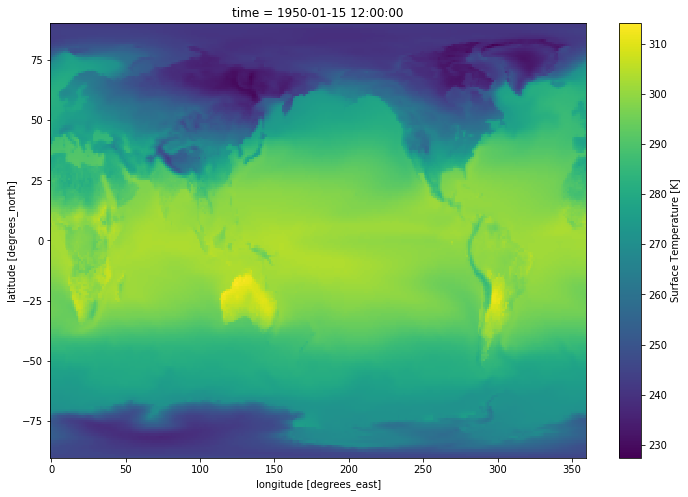

In [4]:
ts.isel(time=0).plot(size=8)

The ocean component has a tripolar grid. This means there are three poles, to avoid having a convergent point in the ocean. All three poles are over land points where there are no wet cells. One pole in the south over Antarctica and two in the north. What this means is that the data have coordinates `i` and `j` and the `lat` and `lon` data variables are 2D and also have coordinates `i` and `j`. The tripolar grid only starts diverging from a normal grid above 60N, so does not affect the calculation of Nino 3.4, but it does make it more difficult to select out the area of interest.

![Tripole Grid](images/tripole.png)

There are a few ways selecting out the region of interest (ROI). 

1. Find the cell indices for the ROI and use `sel`
2. Chop off the tripolar part of the grid and add new 1D lat/lon coordinates to the dataset/variable
3. Use `where` and select for all values within the bounds of interest.

It is the last option that is easiest, for variable `var` it is formulated like so

`var.where((var.lat<5) & (var.lat>-5) & (var.lon>190) & (var.lon<240),drop=True)`

note the `drop=True` option, which will remove all masked cells, which in this case is equivalent to a `sel` operation using `slice` on `lat` and `lon`

In [5]:
ts_nino34 = ts.where((ts.lat<5) & (ts.lat>-5) & (ts.lon>190) & (ts.lon<240), drop=True)

In [6]:
ts_nino34

<xarray.DataArray 'ts' (time: 780, lat: 10, lon: 39)>
array([[[302.1512 , 302.05176, 301.9508 , ..., 299.96567, 299.9341 ,
         299.89536],
        [301.59555, 301.4903 , 301.39032, ..., 299.82025, 299.8067 ,
         299.77975],
        [301.14084, 301.04715, 300.96103, ..., 299.6345 , 299.62805,
         299.60965],
        ...,
        [301.27136, 301.22037, 301.1138 , ..., 300.12805, 300.06195,
         300.05823],
        [301.36053, 301.36926, 301.28888, ..., 300.69922, 300.62277,
         300.58835],
        [301.35733, 301.4219 , 301.4184 , ..., 301.25363, 301.20822,
         301.1783 ]],

       [[302.31226, 302.30505, 302.25766, ..., 300.75427, 300.74057,
         300.72757],
        [301.68616, 301.65005, 301.6025 , ..., 300.69073, 300.7021 ,
         300.7024 ],
        [301.124  , 301.08234, 301.0452 , ..., 300.44217, 300.50232,
         300.5291 ],
        ...,
        [301.05408, 301.00626, 300.99615, ..., 300.45828, 300.4765 ,
         300.46313],
        [301.19156, 301.17178, 301.16977, ..., 300.7428 , 300.74445,
         300.74194],
        [301.23608, 301.21503, 301.18686, ..., 300.94254, 300.9098 ,
         300.8813 ]],

       [[302.72812, 302.70157, 302.6629 , ..., 301.0872 , 301.0281 ,
         300.95184],
        [302.11597, 302.06445, 301.99997, ..., 301.1849 , 301.15894,
         301.11203],
        [301.51553, 301.46024, 301.39984, ..., 301.03098, 301.05838,
         301.02853],
        ...,
        [301.01166, 301.01596, 301.0497 , ..., 300.16556, 300.07516,
         300.0033 ],
        [300.9919 , 301.01688, 301.05066, ..., 300.35098, 300.26007,
         300.1761 ],
        [300.84576, 300.8854 , 300.93857, ..., 300.5253 , 300.43   ,
         300.3289 ]],

       ...,

       [[301.27896, 301.17972, 301.08148, ..., 296.6512 , 296.46127,
         296.32648],
        [300.96655, 300.86038, 300.7601 , ..., 296.0982 , 295.98764,
         295.876  ],
        [300.63248, 300.51672, 300.4158 , ..., 295.65173, 295.60553,
         295.50256],
        ...,
        [300.5872 , 300.56683, 300.4871 , ..., 296.96066, 297.1075 ,
         297.2213 ],
        [300.6796 , 300.6806 , 300.63388, ..., 297.4925 , 297.68356,
         297.92017],
        [301.09058, 301.1097 , 301.106  , ..., 298.48935, 298.59106,
         298.74124]],

       [[301.40002, 301.28052, 301.15414, ..., 297.09952, 297.12994,
         297.10382],
        [301.17438, 301.06982, 300.95062, ..., 296.70465, 296.74615,
         296.77856],
        [300.9266 , 300.83667, 300.7479 , ..., 296.3731 , 296.39917,
         296.45303],
        ...,
        [301.02145, 300.86636, 300.6874 , ..., 296.98764, 297.01654,
         297.28882],
        [301.20917, 301.0797 , 300.94684, ..., 298.01016, 298.0807 ,
         298.28226],
        [301.49152, 301.4111 , 301.29797, ..., 299.02002, 299.079  ,
         299.15503]],

       [[301.57538, 301.49988, 301.42557, ..., 298.0175 , 297.99927,
         297.9859 ],
        [301.28802, 301.20016, 301.11737, ..., 297.6005 , 297.60544,
         297.64288],
        [301.025  , 300.91873, 300.82172, ..., 297.2949 , 297.3104 ,
         297.3539 ],
        ...,
        [300.79974, 300.6729 , 300.52155, ..., 298.72687, 298.6781 ,
         298.3712 ],
        [301.0029 , 300.87308, 300.74554, ..., 299.1676 , 299.0274 ,
         298.68967],
        [301.23648, 301.09424, 301.02063, ..., 299.82724, 299.67538,
         299.4864 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -4.241 -3.298 -2.356 -1.414 ... 2.356 3.298 4.241
  * lon      (lon) float64 191.2 192.5 193.8 195.0 ... 235.0 236.2 237.5 238.8
  * time     (time) object 1950-01-15 12:00:00 ... 2014-12-15 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Surface temperature (skin for open ocean)
    description:    Surface temperature (skin for open ocean)
    frequency:      mon
    id:             ts
    long_name:      Surface Temperature
    mipTable:       Amon
    out_name:       ts
    

In [7]:
print('Check we have the correct spatial extent')
print('Latitude range: {:.1f} - {:.1f}'.format(ts_nino34.lat.min().values, ts_nino34.lat.max().values))
print('Longitude range: {:.1f} - {:.1f}'.format(ts_nino34.lon.min().values, ts_nino34.lon.max().values))

Check we have the correct spatial extent
Latitude range: -4.2 - 4.2
Longitude range: 191.2 - 238.8


Calculate a monthly climatology of mean SST for the 1950-1979 period. Note this should be a single value for each month

In [8]:
ts_nino34_climatology = ts_nino34.sel(time=slice('1950','1979')).groupby('time.month').mean()

Compare the values of climatological mean SST with those from the [classic Trenberth paper](https://doi.org/10.1175/1520-0477(1997)078%3C2771:TDOENO%3E2.0.CO;2)

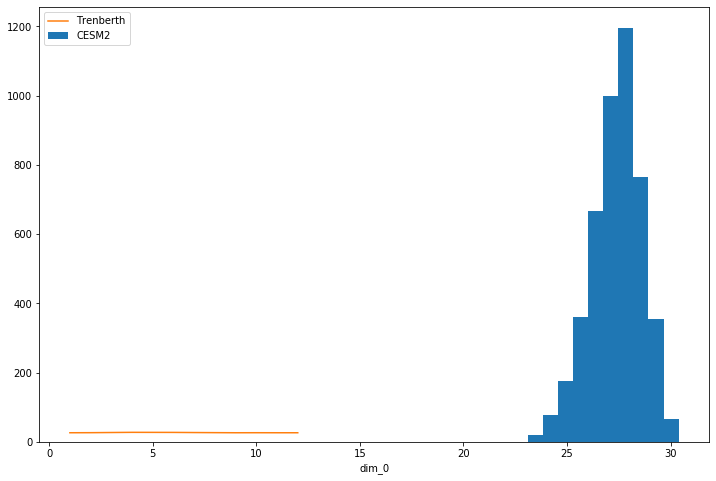

In [9]:
(ts_nino34_climatology - 273).plot(size=8,label='CESM2')
mean_sst_trenberth = xr.DataArray([26.4, 26.6, 27.1, 27.6, 27.5, 27.4, 27.0, 26.7, 26.4, 26.5, 26.4, 26.4], coords=[np.arange(12)+1])
mean_sst_trenberth.plot(label="Trenberth")
plt.legend()

Now calculate the Nino 3.4 index by subtracting the monthly climatology from the original SST data and take the mean over the spatial coordinates (the monthly anomaly of SST over the Nino3.4 region).

In [10]:
index_nino34 = (ts_nino34.groupby('time.month')-ts_nino34_climatology).mean(dim=['lon','lat'])

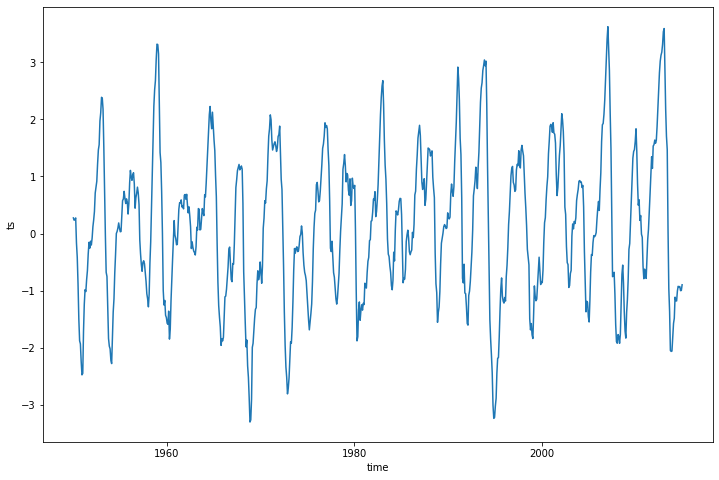

In [11]:
index_nino34.plot(size=8)

Next step is to apply a 5-month moving average smoother. xarray has a method [rolling](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.rolling.html) which can be applied to the your saved variable and then directly plotted

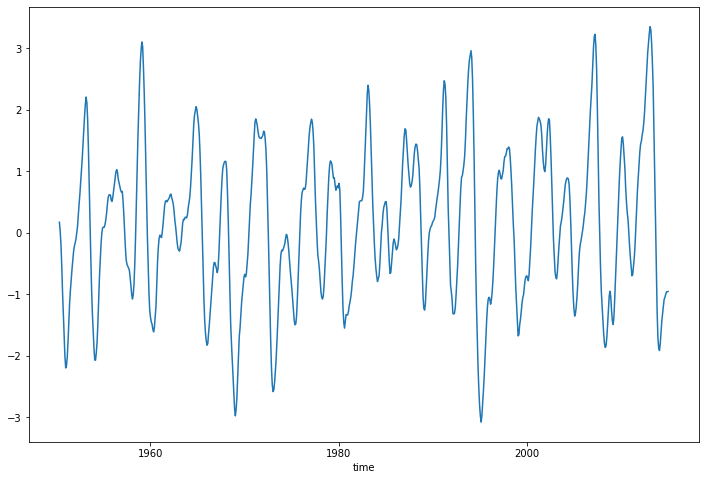

In [12]:
index_nino34.rolling(time=5).mean().plot(size=8)

Last step is to normalise by the standard deviation. Calculate the standard deviation of the SST data in the Nino 3.4 area for the climatological period. xarray provides the [std](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.std.html?highlight=std) operator for this purpose. Save the result in a new variable. Note that this is an average over the entire climatological period, so should be a single value

In [13]:
tas_nino34_climatology_std = ts_nino34.sel(time=slice('1950-01','1979-12')).std()

As the standard deviation is a single value it is sufficient to use the same formulation for your plot as above but divide by the standard deviation and then plot the result. Note that parentheses will be required around the divide operation to correctly chain the `plot()` operator. e.g. something like

`(index_variable.rolling().mean() / std_dev).plot()`

Alternatively, you could save the normalised value into a new variable and then plot that

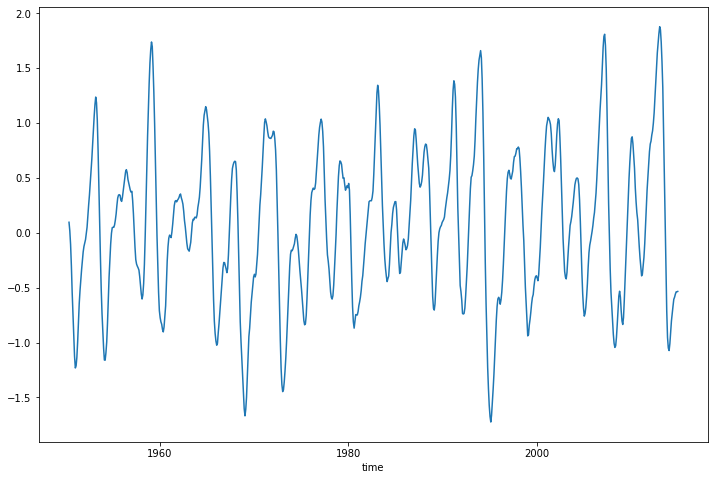

In [14]:
(index_nino34.rolling(time=5).mean() / tas_nino34_climatology_std).plot(size=8)

Add some -0.4/+0.4 lines which are the El Niño threshold

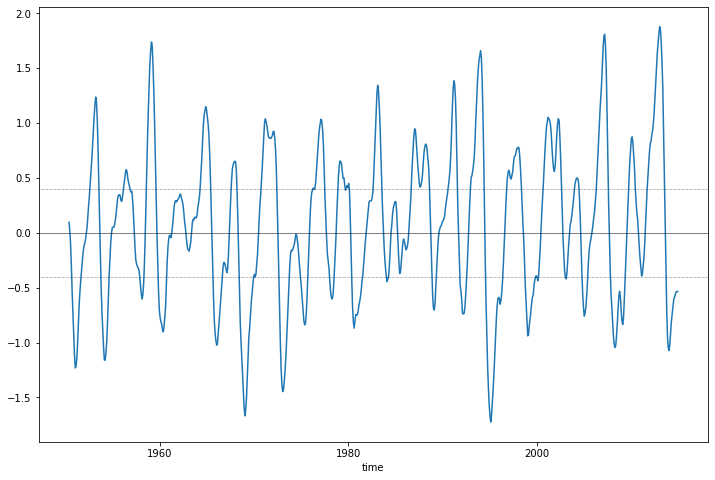

In [15]:
(index_nino34.rolling(time=5).mean() / tas_nino34_climatology_std).plot(size=8)
plt.axhline(0,color='black',lw=0.5)
plt.axhline(0.4,color='black',linewidth=0.5,linestyle='dotted')
plt.axhline(-0.4,color='black',linewidth=0.5,linestyle='dotted')

As an extension, we will re-create the figure from Trenberth

![Trenberth Grid](images/Trenberth.png)

Assign the final Nino 3.4 normalised and smoothed index to a temporary variable for convenience

In [16]:
tmp = (index_nino34.rolling(time=5).mean() / tas_nino34_climatology_std)

To recreate the Nino 3.4 plot from Trenberth requires using the matplotlib function [fill_between](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.fill_between.html) directly. It is called twice, once for the El Nino events, and then again for La Nina. Masking is used to select only values above, or below, a certain threshold, and the same threshold is then used as an argument to `fill_between` to set the other limit of the fill colour.

Text(0.5, 1.0, 'Nino 3.4 Region (Threshold = 0.4 $\\degree$C)')

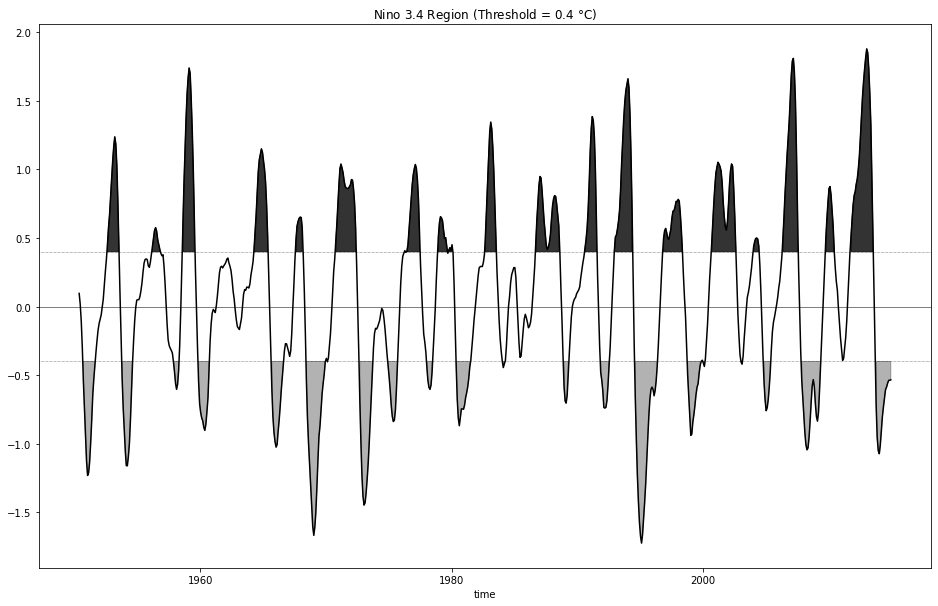

In [17]:
fig = plt.figure(figsize=(16, 10))
plt.fill_between(tmp.time.values, tmp.where(tmp>=0.4).values, 0.4, color='black', alpha=0.8)
plt.fill_between(tmp.time.values, tmp.where(tmp<=-0.4).values, -0.4, color='black', alpha=0.3)
# plt.fill_between(tmp.time.values, tmp.where(tmp<0.4,0.4).where(tmp>-0.4,-0.4).values, color='white')
tmp.plot(color='black')
plt.axhline(0,color='black',lw=0.5)
plt.axhline(0.4,color='black',linewidth=0.5,linestyle='dotted')
plt.axhline(-0.4,color='black',linewidth=0.5,linestyle='dotted')
plt.title('Nino 3.4 Region (Threshold = 0.4 $\degree$C)')


> With these quantitative assignments of events, it is readily seen that there are 177 out of 567 months (January 1950-March 1997) assigned as El Nino (33%) and 133 months assigned as La Nina months (27%). 

In [18]:
"Percentage of El Nino events = {:0.1f}%".format(100 * (tmp.where(tmp>=0.4).count() / tmp.count()).values)

'Percentage of El Nino events = 33.4%'

In [19]:
"Percentage of La Nina events = {:0.1f}%".format(100 * (tmp.where(tmp<=-0.4).count() / tmp.count()).values)

'Percentage of La Nina events = 27.2%'

### Summary

This example shows how to calculate the Nino34 index and define ENSO events. 

## References

https://github.com/coecms-training/introduction_to_xarray

For further information regarding the definition of ENSO please see:

Trenberth, K.E., 1997. The definition of ENSO. Bulletin of the American Meteorological Society, 78(12): 2771-2777.